Объяснимый ИИ - очень важный аспект в ML и DS. Он заключается в том, чтобы интерпретировать решения модели, объяснить,
почему модель сделала именно такое решение. Сегодня я попробую рассказать про это и показать на конкретном примере,
как его можно реализовать.

Но перед тем как объяснять модель необходимо еще написать эффективную модель, а для этого нужно провести исследовательский
анализ данных

Сегодня я буду использовать датасет с данными о мошеннических операциях с банковскими картами.

In [1]:
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings

rcParams['figure.figsize'] = 20, 8
filterwarnings('ignore')

df = pd.read_csv('credit_card_fraud_dataset.csv')

df.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


Теперь надо его преобразовать, а именно, удалить столбцы TransactionID, тк прямого отношения к факту 
мошеннической операции она не имеет (по факту, это просто столбец с индексами строк + 1, тогда как MerchantID - категориальный признак),
но при этом будут вести к переобучению модели в будущем. Также я считаю, что нужно разбить колонку TransactionDate на колонки с датой (TransactionDate),
днем недели (DayOfWeek), часом (TransactionTime), имеет прямое отношение именно час, тк минуты и секунды слишком малы в рамках суток, чтобы иметь
существенное значение в рамках факта мошеннической операции, но при этом будут вести к переобучению модели в будущем

In [2]:
df['TransactionTime'] = pd.to_datetime(df['TransactionDate']).dt.hour
df['TransactionMonth'] = pd.to_datetime(df['TransactionDate']).dt.month
df['DayOfWeek'] = pd.to_datetime(df['TransactionDate']).dt.dayofweek
df['TransactionDate'] = pd.to_datetime(df['TransactionDate']).dt.day
df.drop(columns=['TransactionID'], axis=1, inplace=True)

df.head()


,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud,TransactionTime,TransactionMonth,DayOfWeek
0,3,4189.27,688,refund,San Antonio,0,14,4,2
1,19,2659.71,109,refund,Dallas,0,13,3,1
2,8,784.00,394,purchase,New York,0,10,1,0
3,13,3514.40,944,purchase,Philadelphia,0,23,4,5
4,12,369.07,475,purchase,Phoenix,0,18,7,4


Теперь можно составить список вопросов, основываясь на которых можно будет сделат какой-то вывод, касательно датасета и того, какие факторы влияют на факт
мошеннической операции
Для начала я посмотрю на то, как коррелируют между собой штат и количество мошеннических операций, а также заведу отдельную функцию для построения графиков

<Axes: xlabel='Location'>

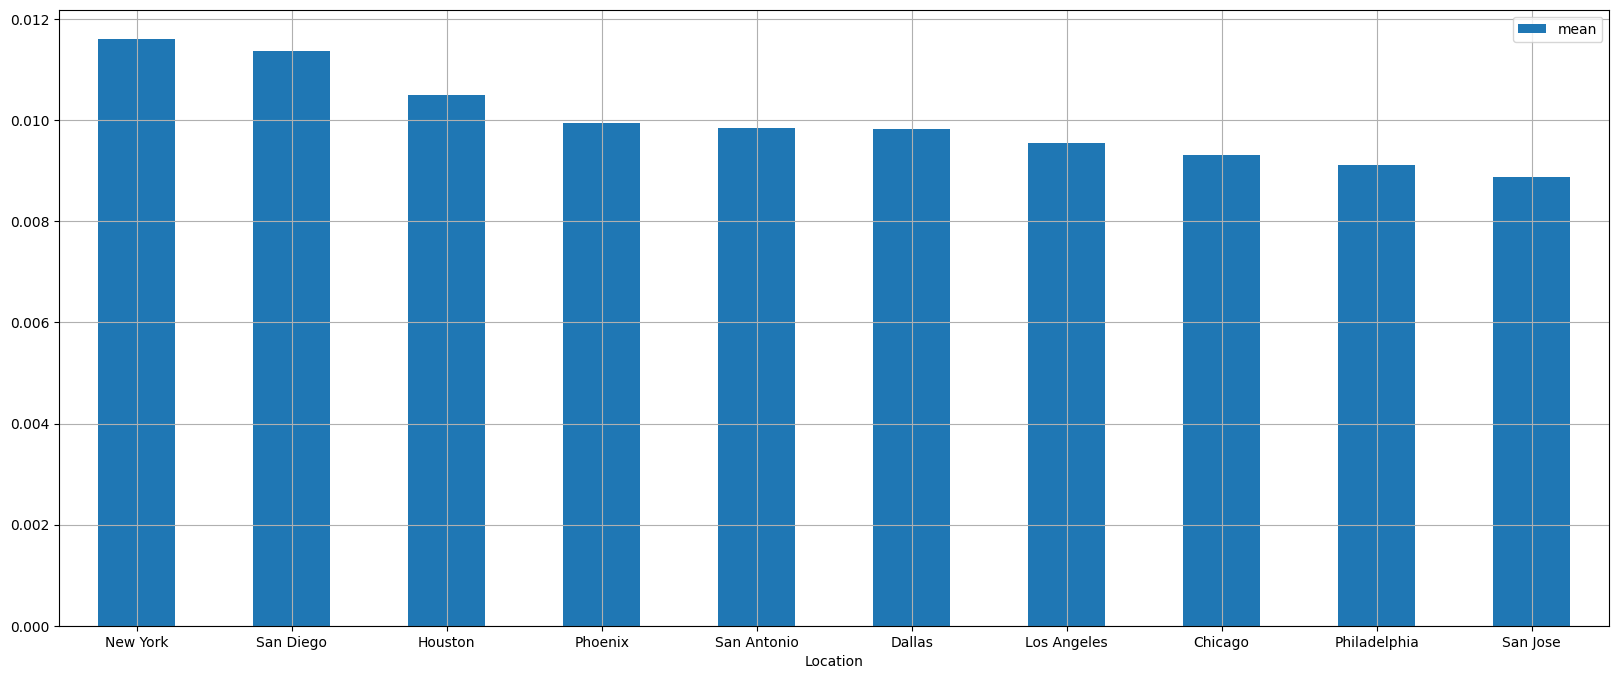

In [3]:
def fraudPlotBasedOnQuestion(df: pd.DataFrame, group: list) -> plt.plot:
    """Builds plot of the amount of frauds per passed group"""

    return df.groupby(group)['IsFraud'].agg([np.mean]).sort_values(by='mean', ascending=False).plot(kind='bar',
                                                                                                    grid=True, rot=0)

fraudPlotBasedOnQuestion(df=df, group=['Location'])


Итак, исходя из графика, можно сказать, что штат оказывает существенное влияние на факт мошенничества, но теперь есть мысли наcчет сильного дисбаланса классов
необходимо проверить это

In [4]:
df['IsFraud'].value_counts()


IsFraud
0    99000
1     1000
Name: count, dtype: int64

Теперь виден огромный дисбаланс классов, но перед тем как с ним разобраться, надо дальше проверить корреляции
Следуюший вопрос: как коррелируют между собой время суток и количество мошеннических операций
Потому что вполне вполне возможен тот факт, что большинство мошеннических операций проводятся вечером

<Axes: xlabel='TransactionTime'>

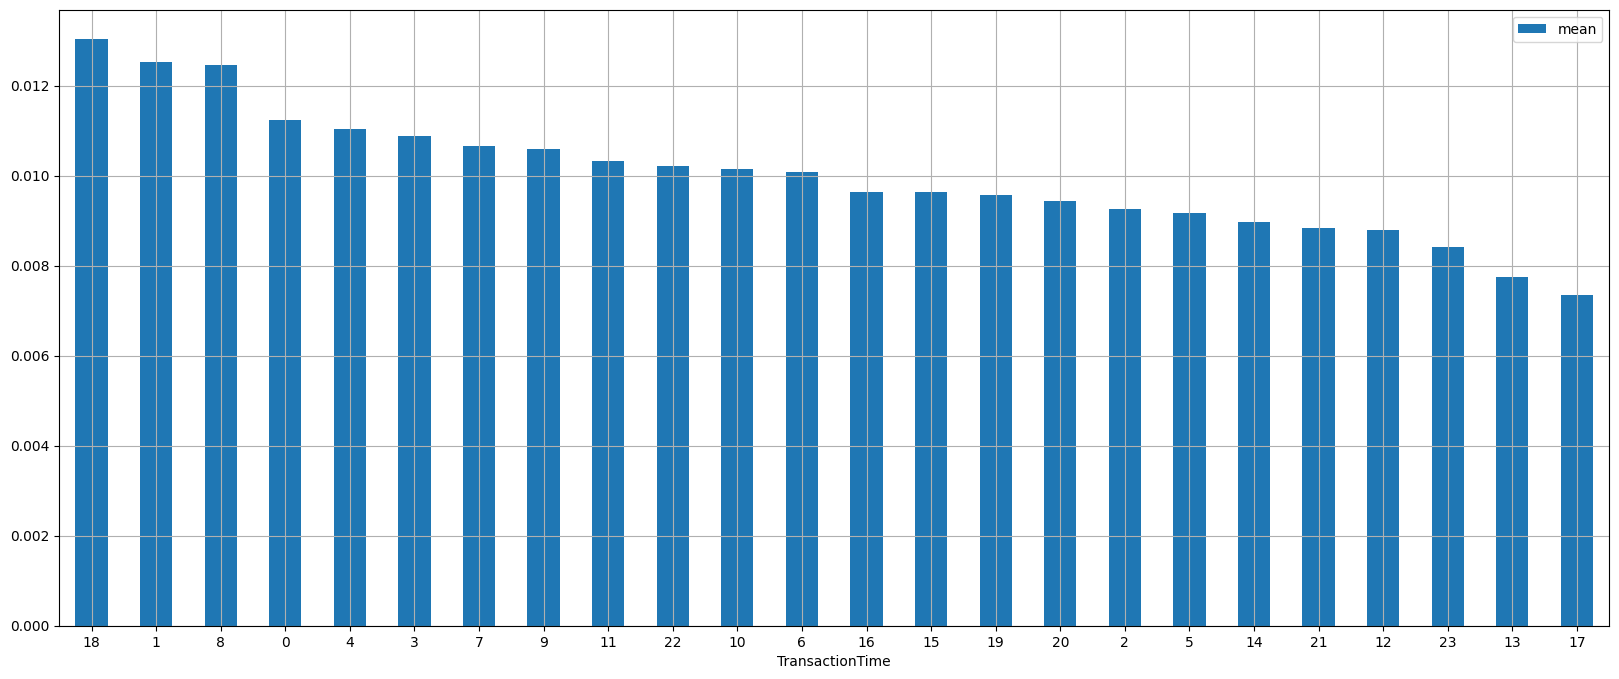

In [5]:
fraudPlotBasedOnQuestion(df=df, group=['TransactionTime'])


Из этого графика видно, что время суток также оказывает существенное влияние на количество мошеннических операций: 
Наибольшее количество, с весьма большим отрывом, забирают 6 вечера, 1 час ночи, 8 утра, 12 ночи, 4 утра
Далее из графика и топа 5 видно, что большинство мошеннических операций проводятся в часы, когда люди наиболее плохо соображают (за некоторым исключением)
Теперь имеет смысл посмотреть на эту же корреляцию, но в зависимости от дня недели

<Axes: xlabel='DayOfWeek'>

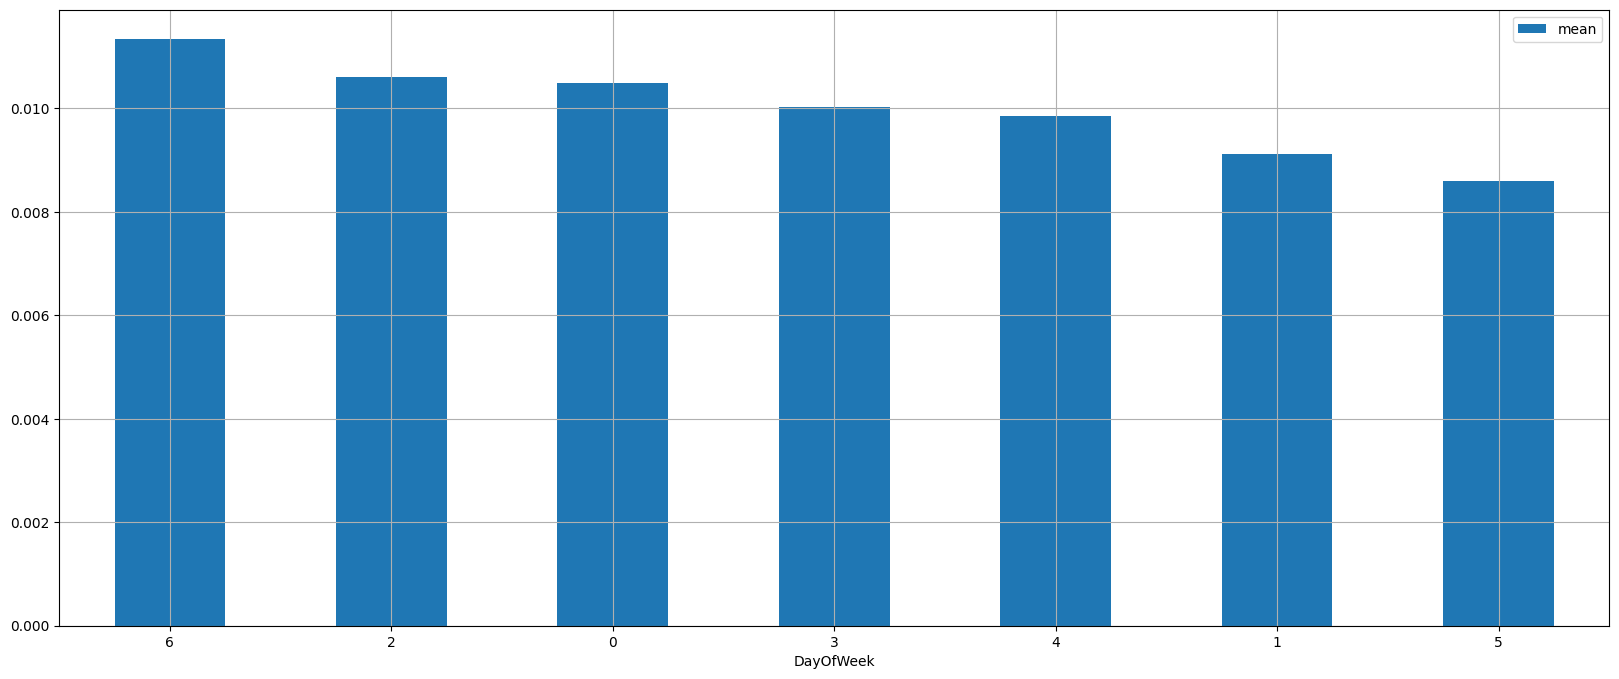

In [6]:
fraudPlotBasedOnQuestion(df=df, group=['DayOfWeek'])


Из этого графика хорошо видно, что день недели также влияет на количество мошеннических операций, самое большое количество - воскресенье, 
самое маленькое - суббота, но в остальном. чем ближе к выходным. тем выше количество операций растет
Теперь посмотрим на медианное значение трат в зависимости от типы операции (возврат / покупка), тк в теории, если деньги будут отмывать, то скорее будут делать
возрат

<Axes: xlabel='TransactionType'>

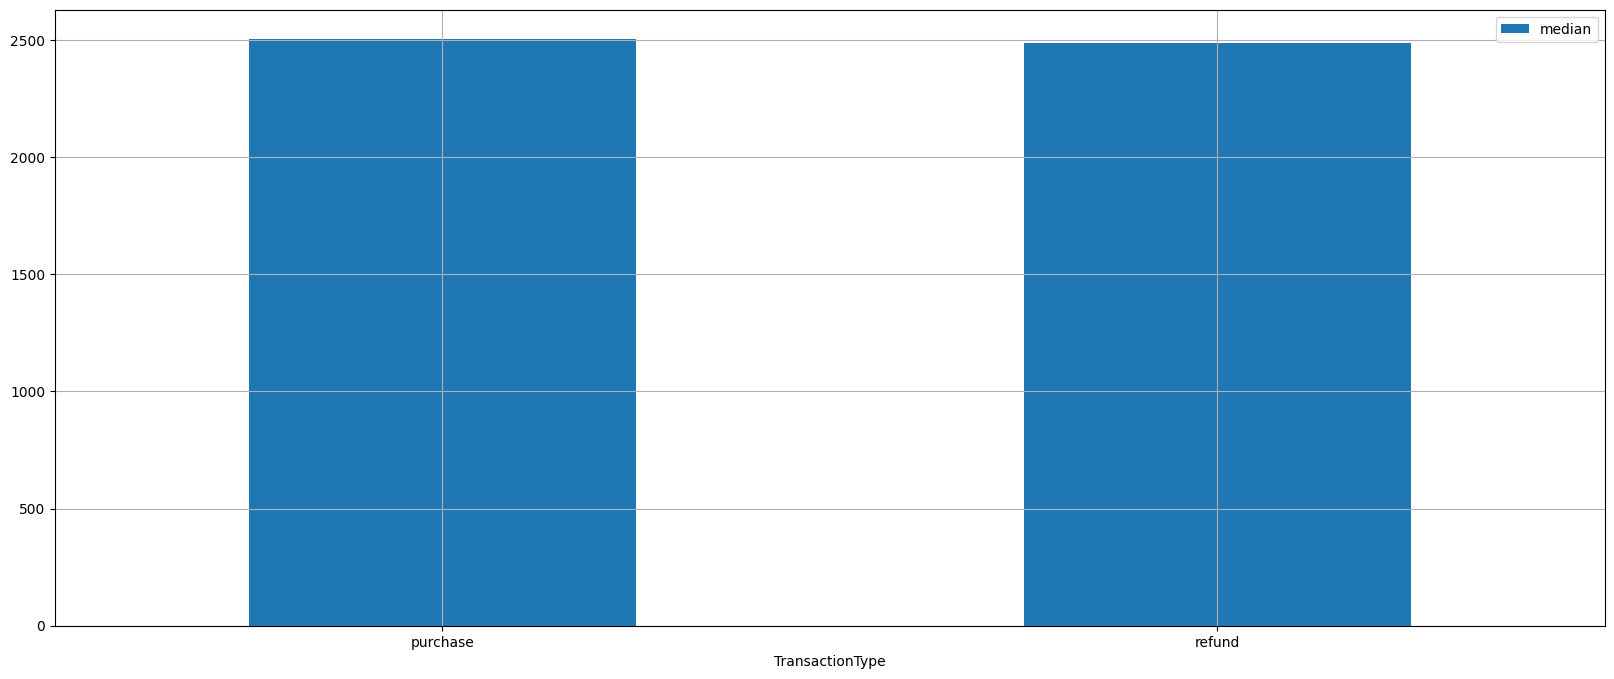

In [7]:
df.groupby(['TransactionType'])['Amount'].agg([np.median]).sort_values(by='median',
                                                                                      ascending=False).plot(kind='bar',
                                                                                                            grid=True,
                                                                                                            rot=0)


Отсюда видно, что медианное (среднее и дисперсия также примерно равны) значение суммы операции не зависит от типа операции

<Axes: xlabel='TransactionType'>

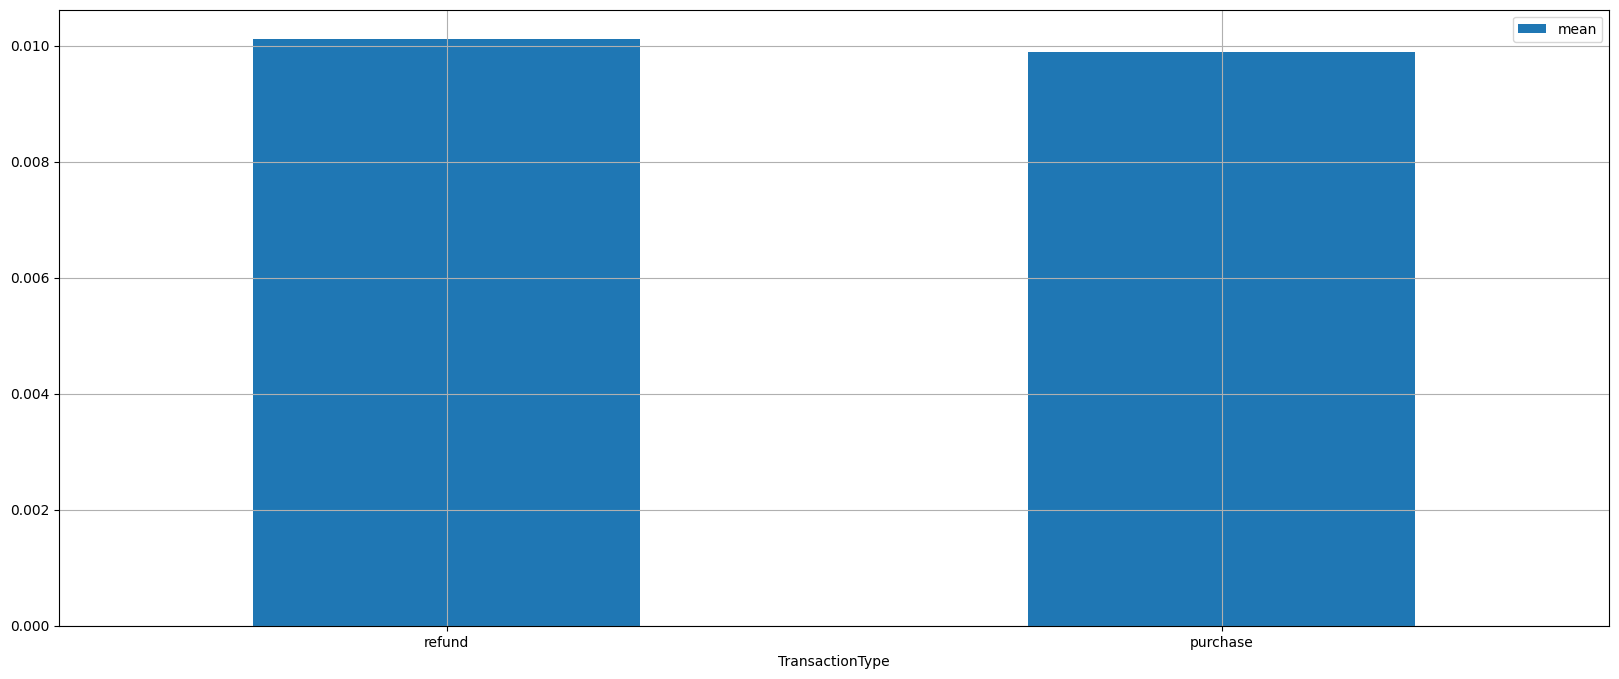

In [8]:
fraudPlotBasedOnQuestion(df=df, group=['TransactionType'])


Отталкиваясь от графика видно, что количество мошеннических операций при возврате больше, но при этом и самих возвратов тоже больше, поэтому имеет смысл
посмотреть на среднее количество мошеннических операций в зависимости от типа операции

**Обучение модели**

Теперь, когда EDA проведен можно приступить к обучению модели. В сегодняшнем случае я буду использовать
RandomForestClassifier, потому что он сам по себе довольно простой и очень хорошо интерпретируется. Это происходит
из-за его нехитрого принципа работы, а именно:
Он строится на том, что датасет разбивается на отдельные небольшие датасеты с слегка другим набором данных,
на каждом из которых обучается отдельное дерево решений, далее, все результаты, полученные деревьями усредняются с помощью
бэггинга и выносится финальное решение. Отсюда и вытекает его хорошая интерпретируемость, также его, при желании, можно
разбить просто на набор условий. 
Перед началом обучения модели необходимо разобраться с дисбалансом классов, который мы увидели, а также преобразовать, чтобы избежать переобучения (если разобраться с дисбалансом классов недообучение отпадет само собой из-за
большого размера выборки). К тому же надо еще разобраться с категориальными признаками, так как RFC из sklearn нативно с ними
не работает. 

In [9]:
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df['Location'] = encoder.fit_transform(df[['Location']])
df['TransactionType'] = encoder.fit_transform(df[['TransactionType']])


class Model(ABC):

    @abstractmethod
    def createTest(df: pd.DataFrame) -> tuple:
        """splits dataframe for test and reduces class imbalance"""

        x = df.drop(['IsFraud'], axis=1)
        y = df['IsFraud']
        cat_features = ['Location', 'TransactionType', 'TransactionTime', 'TransactionMonth', 'TransactionDate',
                        'DayOfWeek', 'MerchantID']
        cat_features_dict = {i: (x[i].min(), x[i].max()) for i in cat_features}

        pipeline = Pipeline(steps=[
            ('over', RandomOverSampler(random_state=52)),
        ])

        x, y = pipeline.fit_resample(x, y)

        # защита от того, что механизмы сэмплеров могут выйти за границы исходных данных
        for i in cat_features:
            x[i] = x[i].clip(lower=cat_features_dict[i][0], upper=cat_features_dict[i][1])

        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17, shuffle=True)

        return X_train, X_test, y_train, y_test

    @abstractmethod
    def learn(df: pd.DataFrame) -> None:
        return
    


теперь же можно обучить модель, а также оценить ее, делать это я буду при помощи classification_report, так как тут можно
увидеть сразу все основные метрики, такие как precision, recall, f1-score, а также микро и макро усреднение эти метрик

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

class RandomForest(Model):

    def learn(df: pd.DataFrame) -> RandomForestClassifier:
        """builds Random Forest Classifier"""

        X_train, X_test, y_train, y_test = Model.createTest(df)

        clf = RandomForestClassifier(n_estimators=100, random_state=52)
        clf.fit(X_train, y_train)

        return clf

X_test = Model.createTest(df)[1]
y_test = Model.createTest(df)[3]
print(classification_report(y_test, RandomForest.learn(df).predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29625
           1       1.00      1.00      1.00     29775

    accuracy                           1.00     59400
   macro avg       1.00      1.00      1.00     59400
weighted avg       1.00      1.00      1.00     59400



Теперь, модель обучена и ее результаты нас вполне устраивают, можно переходить к следующему шагу

**Интерпретация модели**

Для интерпретации я буду использовать библиотеку shap и модуль AnchorTabular из библиотеки alibi (хотя alibi и LIME очень схожи и 
конкретно в этом случае можно использовать LIME, лучше все же alibi, потому что проблема с LIME в том, что она только 
охватывает местный регион, который может дать чрезмерную уверенность в объяснении и может не подходить для экземпляра, 
который не подготовлен) 
Для начала необходимо уменьшить выборку, потому что результат для выборки свыше 100 принципиально не меняется, но при это время выполнения кратно увеличивается,
для того, чтобы графики выглядели более плотно и их было чуть проще интепретировать, размер выборки я сделаю равным 200.

In [11]:
import shap
from alibi.explainers import AnchorTabular
from alibi.utils import gen_category_map
import tqdm
import re


X_train = Model.createTest(df)[0]
X_test = Model.createTest(df)[1]
model = RandomForest.learn(df)
sampleSize = 200

cat_map = gen_category_map(X_train)
X_train = shap.sample(X_train, sampleSize)
X_test = shap.sample(X_test, sampleSize)
features = X_train.columns.tolist()


2024-11-06 16:51:23.841656: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 16:51:23.977252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730901084.031067    6513 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730901084.046853    6513 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 16:51:24.173541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

теперь получим значения Шепли (они оценивают то, какой вклад внес каждый отдельно взятый признак в итоговое решение модели) , потому что сначала с их помощью мы 
будем смотреть на то, на какие признаки модель смотрит больше всего для этого я буду использовать KernelExplainer, потому что он тут работает не слишком долго и 
при этом - это самый универсальный способ для объяснения, так что этот код будет работать и для любой другой модели (если надо конкретно для "деревянных" моделей 
можно использовать TreeExplainer)

In [12]:
ex = shap.KernelExplainer(model.predict, X_train)
shap_values = ex.shap_values(X_test)
expected_value = ex.expected_value
shap_explained = shap.Explanation(shap_values, feature_names=features)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [01:37<00:00,  2.06it/s]


Теперь, когда значения получены можно посмотреть на сами графики этих значение

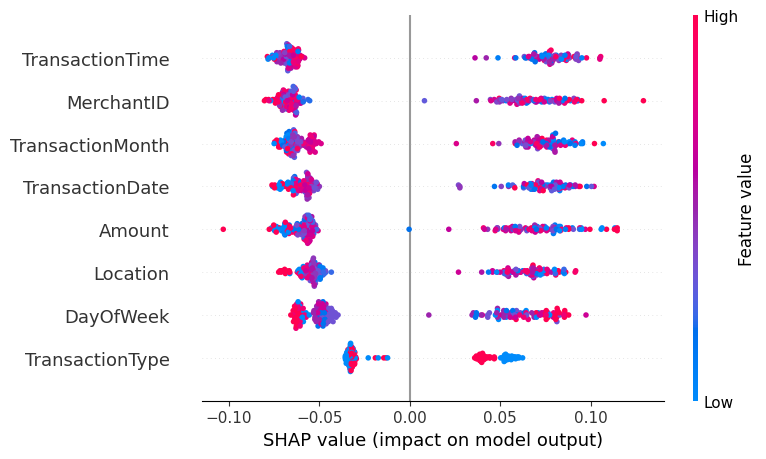

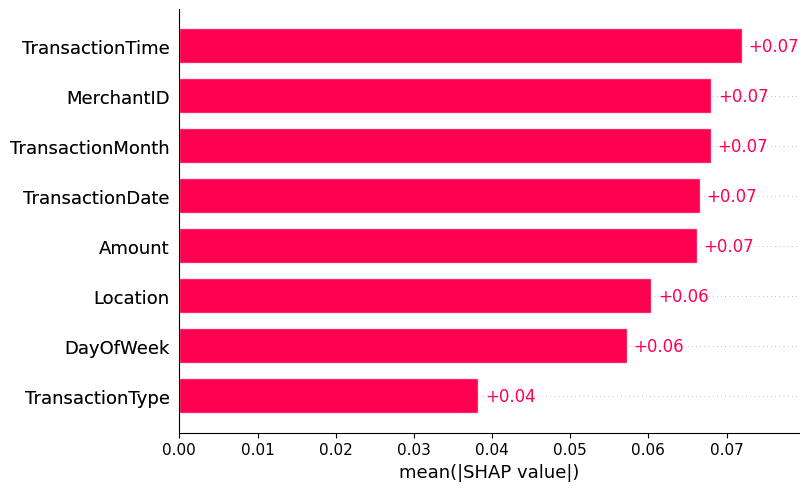

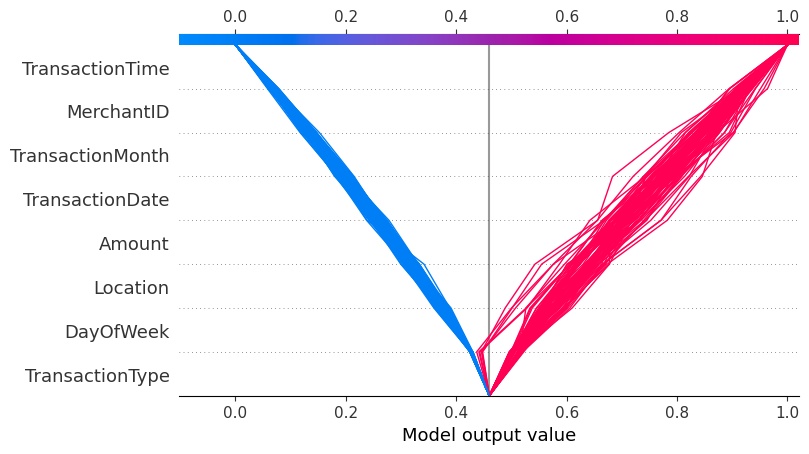

In [13]:
shap.summary_plot(shap_explained, X_test, feature_names=features)

shap.plots.bar(shap_values=shap_explained, max_display=len(features))

shap.plots.decision(base_value=expected_value, shap_values=shap_values,
                            feature_names=features)


Итак, исходя из графиков видно, что для модели все данные имеют примерно равное значение, также можно сделать вывод, что в некоторых штатах уровень 
мошеннических операций выше, также как и в зависимости даты, также, чем больше сумма операции, тем выше вероятность мошенничества
Теперь сравним эти графики с графиком частоты появления каждого признака в объяснениях AnchorTabular

**AnchorTabular**

начало тут примерно такое же, отличия пойдут только с момента создания объекта AnchorTabular и его обучение, 

код для этого 

In [14]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

ex = AnchorTabular(model.predict, feature_names=features, categorical_names=cat_map)
ex.fit(X_train)


AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.6'}
)

Итак, ввиду того, что AnchorTabular выдает ответ для одной конкретной строки, придется написать простенький алгоритм, который будет получать объяснение для каждой
строки, далее по списку с объяснениями пробегаться и, посредством регулярного выражения, получать каждый отдельный признак и подсчитывать его частоту встречаемости
потом записывать ее в словарь 


In [15]:
res = {x: 0 for x in features}
for i in tqdm.tqdm(range(sampleSize)):

    explanation = ex.explain(X=X_test[i], threshold=0.98)
    temp = explanation.data['anchor']

    if len(temp) > 0:
        for x in temp:
            res[re.search('[a-z]+', x, flags=re.IGNORECASE).group()] += 1


100%|██████████| 200/200 [05:10<00:00,  1.55s/it]


Теперь можно отсортировать полученный словарь и построить график частоты встречаемости каждого из признаков

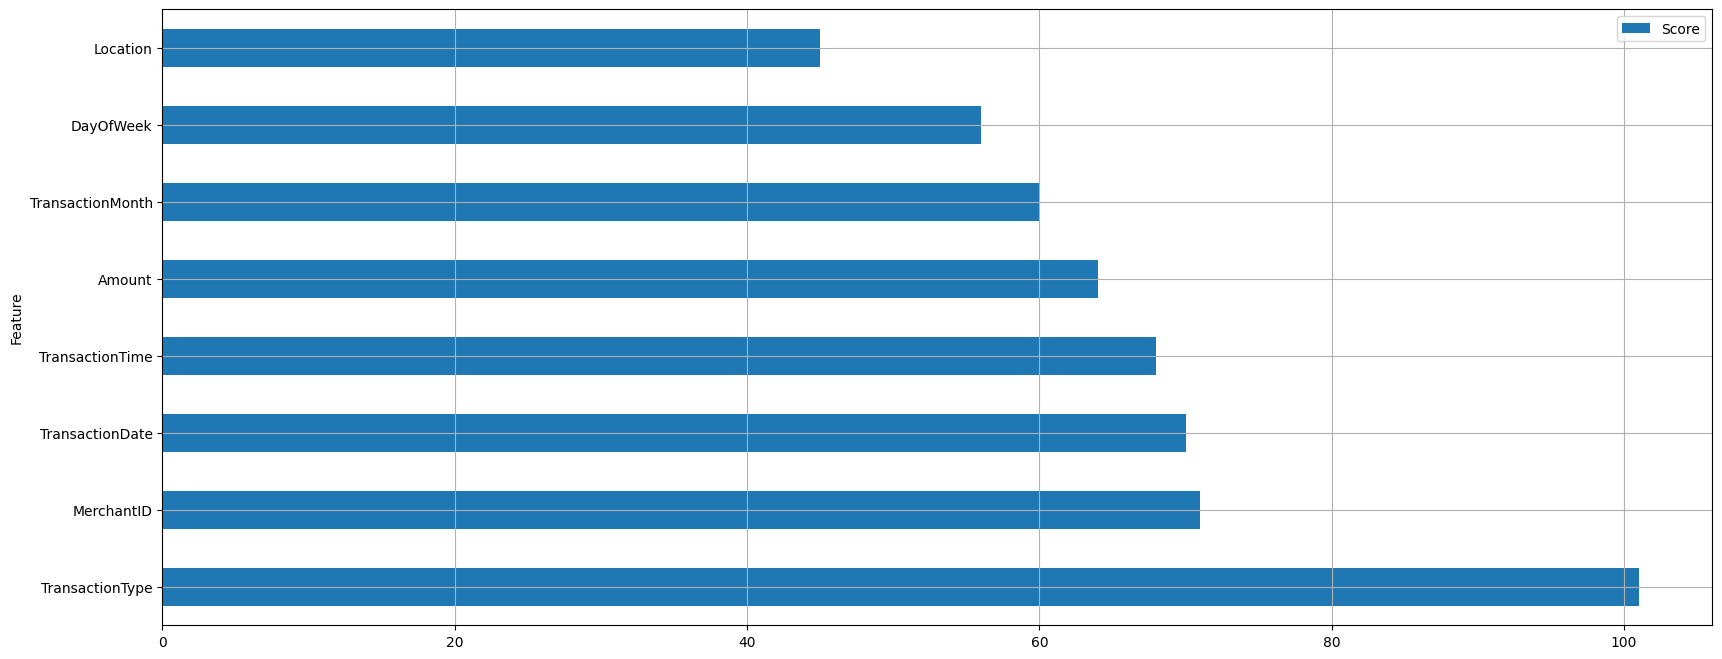

In [16]:
anchorAppearences = sorted(res.items(), key=lambda x: x[1], reverse=True)
data = pd.DataFrame(data=anchorAppearences, columns=['Feature', 'Score'])
data.plot(kind='barh', y='Score', x='Feature', grid=True)
plt.show()
        

Графики получились весьма разные, смотря на этот график, наименьшее значение имеет штат, хотя, исходя из первых графиков, его важность была
чуть ниже среднего (на фоне остальных признаков), но, тем не менее, он привносиь большое значение для итогового решения в модели, также это подтверждает
график частоты мошеннических операций в зависимости от местоположения, но с другой стороны получается, что самое большое значение для модели оказал признак 
типа операции (возврат/покупка), я думаю, что это могло произойти из-за того, что AnchorTabular просто подбирает такой набор значений, чтобы
максимизировать охват при ограничении точности, тогда как shap оценивает именно вклад в итоговый результат для самой модели, 
поэтому и могут быть такие различия в графиках
В конце можно подытожить, что хоть тип транзации и появлялся в интерпретациях AnchorTabular чаще всего, 
вклад в итоговые решения модели он оказал самый маленький, а признак места наоборот, хоть и встречался реже всего, но тем не менее, для модели значил
больше, чем тип транзакции (это же подтверждают графики из EDA). Но при всем при этом признак часа, в котором проводилась операция оказался на втором
месте по частоте встречаемости, тогда как в итоговое решение модели он оказал самое большое значение. Тоже самое применимо и для остальных признаков
также, для большинства признаков вклад примерно совпадает с графиками из EDA, так что эти показатели можно считать более-менее достоверными

**Итог**

В качестве итога хочу сказать, что методы интерпретации мл моделей помогают заглянуть в "черный ящик" и лучше понять то, какие признаки для модели оказываются наиболее важными, так же с их помощью можно улучшать уже имеющиеся модели